Capstone Project by Parvez Noorani

### Grocery Prediction and recommendation

#### * Importing Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color=sns.color_palette()
pd.options.mode.chained_assignment = None # so warning are removed

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### * Loading files and seeing top few data

In [0]:
aisles_df=pd.read_csv("/content/drive/My Drive/Grocery/aisles.csv")
departments_df=pd.read_csv("/content/drive/My Drive/Grocery/departments.csv")
order_products__prior_df=pd.read_csv("/content/drive/My Drive/Grocery/order_products__prior.csv")
order_products__train_df=pd.read_csv("/content/drive/My Drive/Grocery/order_products__train.csv")
orders_df=pd.read_csv("/content/drive/My Drive/Grocery/orders.csv")
products_df=pd.read_csv("/content/drive/My Drive/Grocery/products.csv")

In [0]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [0]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [0]:
order_products__prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [0]:
order_products__train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [0]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [0]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


#### * From above we can see that orders.csv has all info about the order number,id, days since prior order,etc. Now we will predict itmes which will be re-ordered.

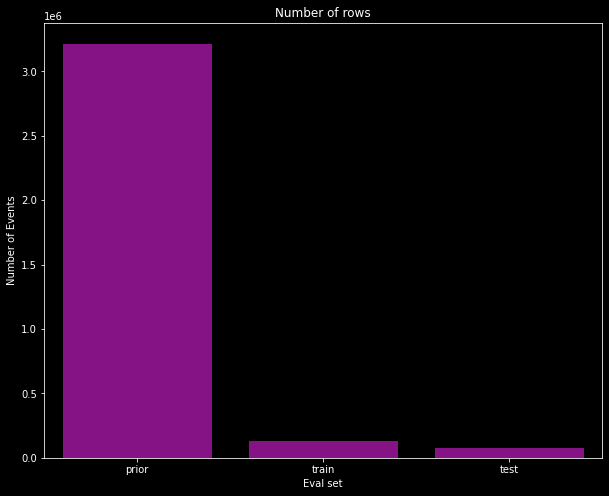

In [0]:
count_srs=orders_df.eval_set.value_counts()
plt.figure(figsize=(10,8))
sns.barplot(count_srs.index,count_srs.values,alpha=0.8,color='m')
plt.ylabel('Number of Events',fontsize=10)
plt.xlabel('Eval set',fontsize=10)
plt.title('Number of rows',fontsize=12)
plt.style.use('dark_background')
plt.show()

In [0]:
count_srs=orders_df.groupby("eval_set").agg({"user_id": "nunique"}).reset_index()
print(count_srs)

  eval_set  user_id
0    prior   206209
1     test    75000
2    train   131209


#### * From above we can inference there are 206209 from which 131209 are trained and we will predict for rest 75000 customers

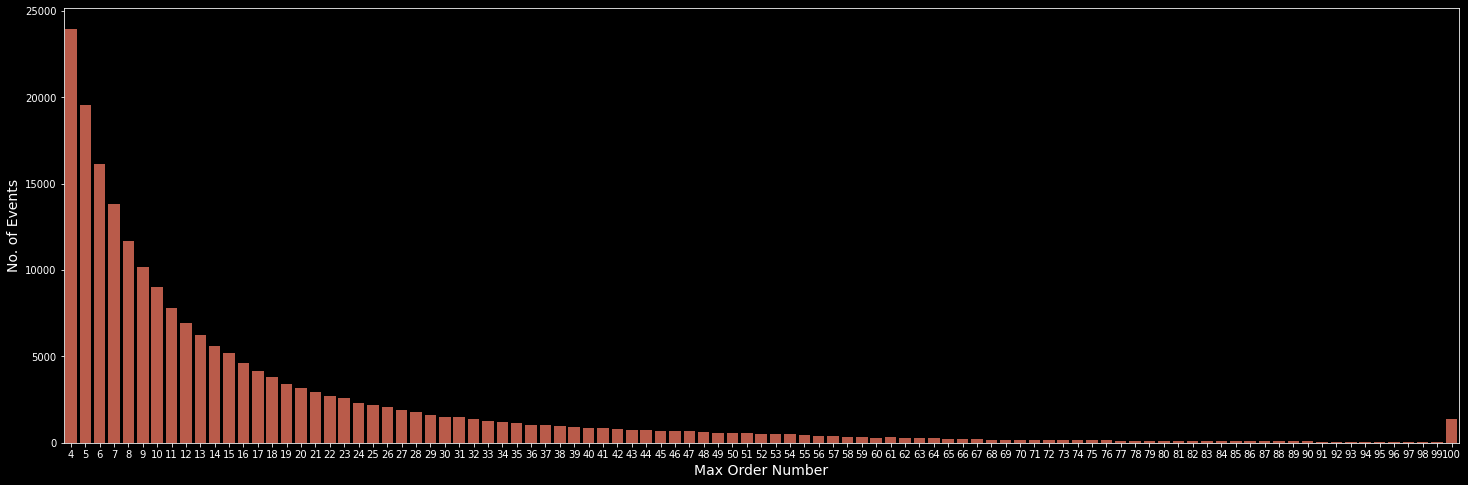

In [0]:
count_srs=orders_df.groupby("user_id")["order_number"].agg(np.max).reset_index().order_number.value_counts()
plt.figure(figsize=(25,8))
sns.barplot(count_srs.index,count_srs.values,alpha=0.8,color='tomato')
plt.ylabel('No. of Events',fontsize=14)
plt.xlabel('Max Order Number',fontsize=14)
plt.style.use('dark_background')
plt.show()

#### * From above we see orders are between 4 and 100 as in data

#### * Now we will see order habits of customer with day of the week

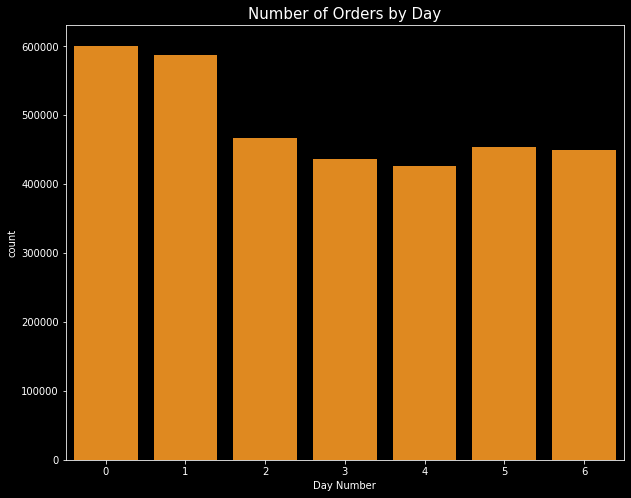

In [0]:
plt.figure(figsize=(10,8))
sns.countplot(x='order_dow',data=orders_df,color='darkorange')
plt.xlabel('Day Number',fontsize=10)
plt.title('Number of Orders by Day',fontsize=15)
plt.style.use('dark_background')
plt.show()

#### * From above it seems 0 and 1 are Saturday and Sunday and 4 seems to be Wednesday when number of orders are low.

#### * Now we will see order habits of customer with time of day

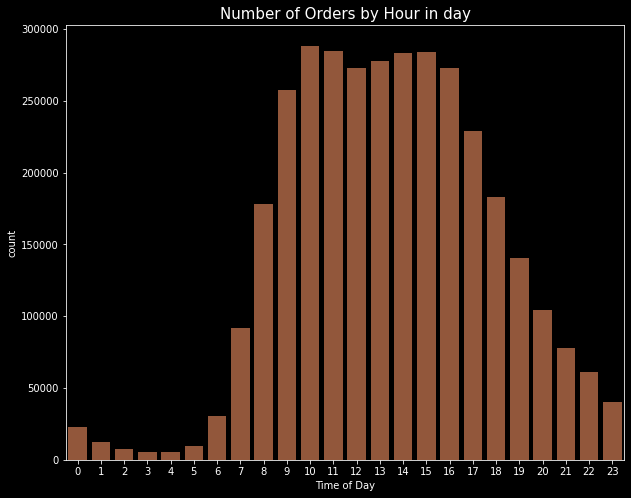

In [0]:
plt.figure(figsize=(10,8))
sns.countplot(x='order_hour_of_day',data=orders_df,color='sienna')
plt.xlabel('Time of Day',fontsize=10)
plt.title('Number of Orders by Hour in day',fontsize=15)
plt.style.use('dark_background')
plt.show()

#### * From above it seems mostly orders are placed in the day time.

#### * Now we will merge day of week and time of day to analyse distribution

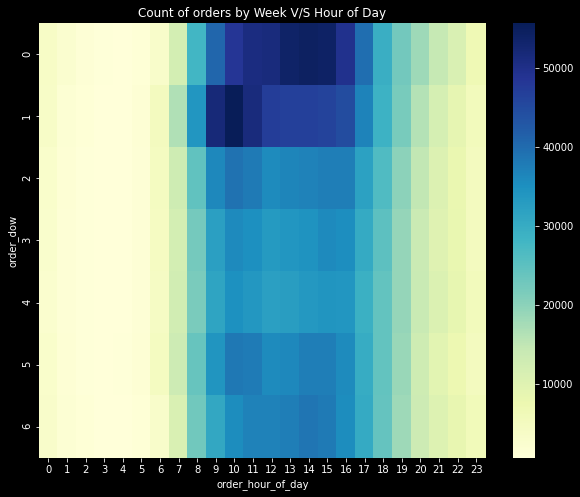

In [0]:
group_df=orders_df.groupby(['order_dow','order_hour_of_day'])['order_number'].agg('count').reset_index()
group_df=group_df.pivot("order_dow","order_hour_of_day","order_number")
plt.figure(figsize=(10,8))
sns.heatmap(group_df,cmap="YlGnBu")
plt.title('Count of orders by Week V/S Hour of Day')
plt.style.use('dark_background')
plt.show()

#### * From above it seems Saturday evening and Sunday morning is the peak time for orders.
#### * Now we will check the gap between 2 orders by the customer.

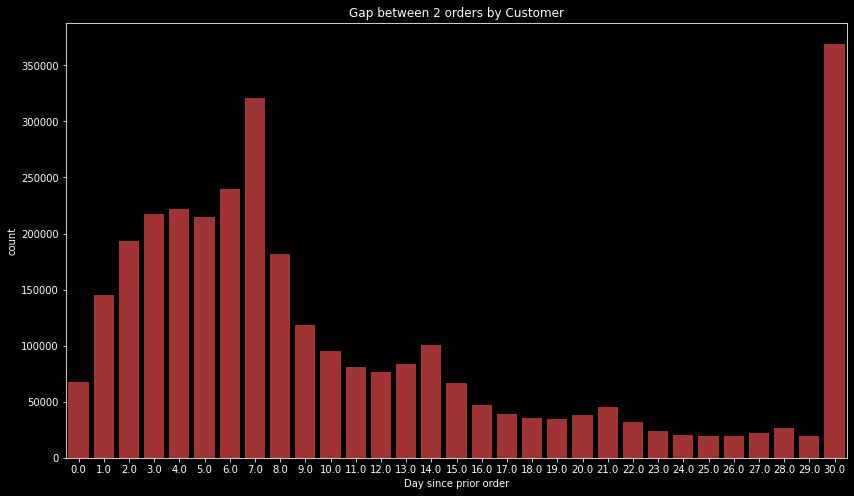

In [0]:
plt.figure(figsize=(14,8))
sns.countplot(x='days_since_prior_order',data=orders_df,color='firebrick')
plt.xlabel("Day since prior order", fontsize=10)
plt.title("Gap between 2 orders by Customer",fontsize=12)
plt.style.use('dark_background')
plt.show()

#### * From above it seems majority customers  prefer ordering once in 7 days or 30 days and there is some good frequency at 14th, 21st day, 28th days i.e. weekly intervals.

#### * Our next goal will be to find re-ordered products percentage by customers from prior and train set

In [0]:
order_products__prior_df.reordered.sum() / order_products__prior_df.shape[0]*100

58.969746679221615

In [0]:
order_products__train_df.reordered.sum() / order_products__train_df.shape[0]*100

59.859441275096295

#### * Around 59% of the products in ordeer are re-ordered products

#### * There will also be scenarios where none products are re-ordered. We will check that now for prior and train.

In [0]:
group_df=order_products__prior_df.groupby('order_id')['reordered'].agg('sum').reset_index()
group_df['reordered'].loc[group_df['reordered']>1]=1
group_df.reordered.value_counts()/group_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [0]:
group_df = order_products__train_df.groupby('order_id')['reordered'].agg('sum').reset_index()
group_df['reordered'].loc[group_df['reordered']>1] = 1
group_df.reordered.value_counts() / group_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

#### * Around 12% of the customer order has no re-ordered products in prior set whereas in train set it is 6.5%

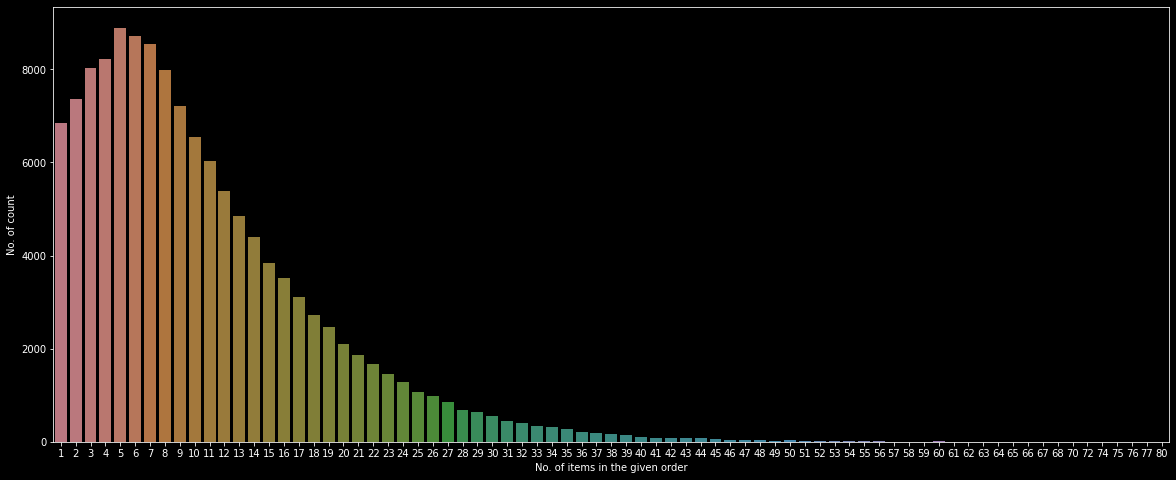

In [0]:
group_df=order_products__train_df.groupby('order_id')['add_to_cart_order'].agg('max').reset_index()
count_srs=group_df.add_to_cart_order.value_counts()
plt.figure(figsize=(20,8))
sns.barplot(count_srs.index, count_srs.values, alpha=0.8)
plt.ylabel('No. of count',fontsize=10)
plt.xlabel('No. of items in the given order', fontsize=10)
plt.style.use('dark_background')
plt.show()

#### * It is a Right Skewed Distribution

#### * We will merge the unused data which we have i.e.products,aisles,departments

In [0]:
order_products__prior_df = pd.merge(order_products__prior_df, products_df, on='product_id', how='left')

In [0]:
order_products__prior_df = pd.merge(order_products__prior_df, aisles_df, on='aisle_id', how='left')

In [0]:
order_products__prior_df = pd.merge(order_products__prior_df, departments_df, on='department_id', how='left')

In [0]:
order_products__prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


#### * Now we will get product name with top frequency count

In [0]:
count_srs=order_products__prior_df["product_name"].value_counts().reset_index().head(20)
count_srs.columns=['product_name','frequency_count']
count_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


#### * From above top frequency majorly is organic products specially organic fruits.

#### * Now we will see important Aisles

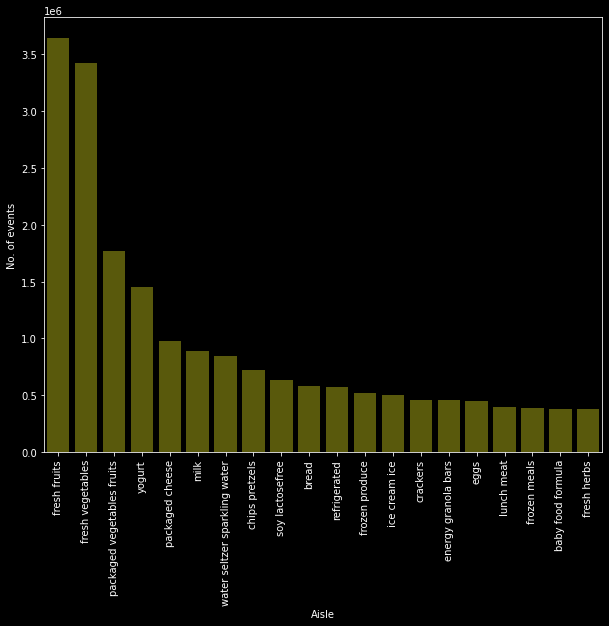

In [0]:
count_srs = order_products__prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(10,8))
sns.barplot(count_srs.index, count_srs.values, alpha=0.8, color='olive')
plt.ylabel('No. of events', fontsize=10)
plt.xlabel('Aisle', fontsize=10)
plt.xticks(rotation='vertical')
plt.style.use('dark_background')
plt.show()

#### * From above it is clear that the top aisles are fresh fruits and vegetables.

#### * Let's give a look at Department wise distribution

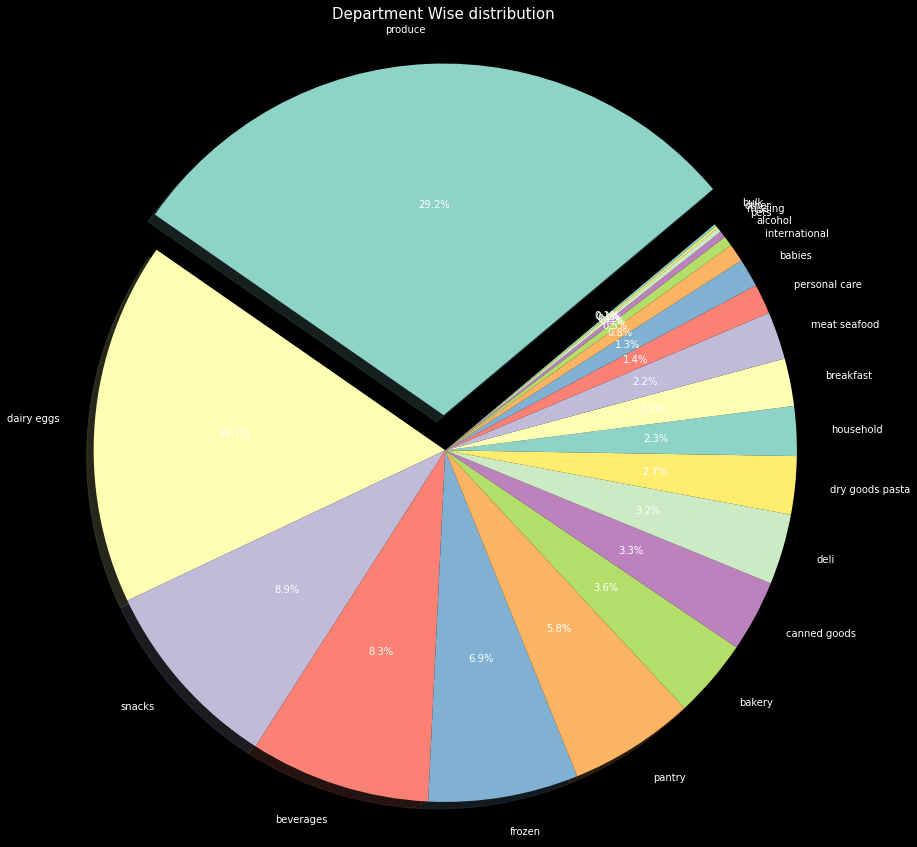

In [0]:
plt.figure(figsize=(15,15))
temp_series=order_products__prior_df['department'].value_counts()
labels=(np.array(temp_series.index))
sizes=(np.array((temp_series/temp_series.sum())*100))
explode=(0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)
plt.pie(sizes,explode=explode,labels=labels,autopct='%1.1f%%',shadow=True,startangle=40)
plt.axis('equal')
plt.title("Department Wise distribution",fontsize=15)
plt.show()

#### * From above it is clear that Produce is the largest department.

#### * Let us have a look at the re-ordered %  by Department wise

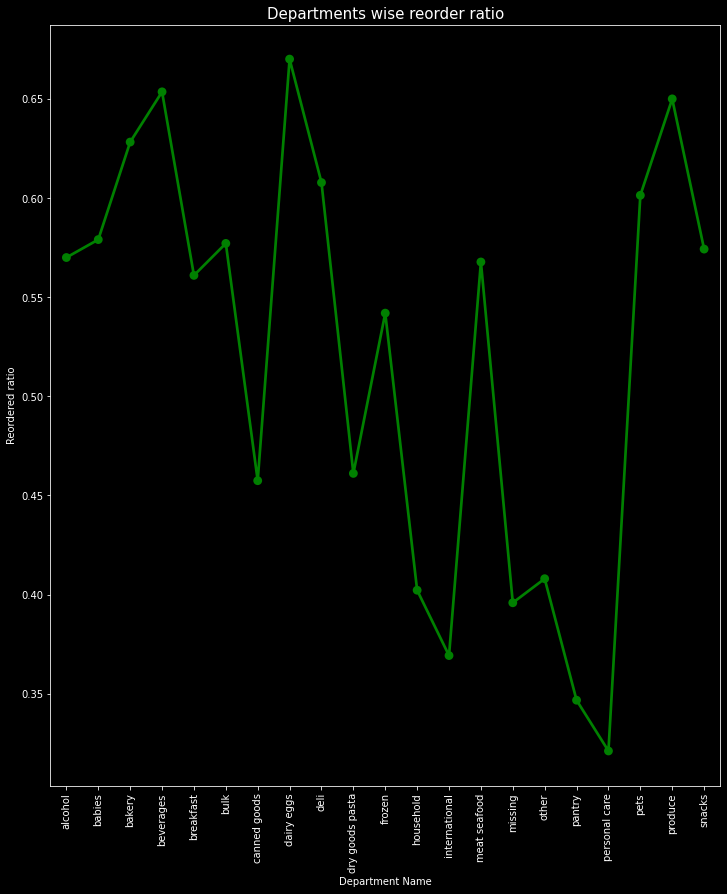

In [0]:
group_df=order_products__prior_df.groupby(["department"])["reordered"].agg("mean").reset_index()
plt.figure(figsize=(12,14))
sns.pointplot(group_df['department'].values,group_df['reordered'].values,alpha=0.8,color='green')
plt.ylabel('Reordered ratio',fontsize=10)
plt.xlabel('Department Name',fontsize=10)
plt.title("Departments wise reorder ratio",fontsize=15)
plt.xticks(rotation='vertical')
plt.style.use('dark_background')
plt.show()

#### * From above personal care has least reordered ratio whereas dairy eggs being the highest.